In [90]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [91]:
import os

os.path.isfile("/content/drive/MyDrive/Online Retail.xlsx")

True

In [92]:
FILE_PATH = "/content/drive/MyDrive/Online Retail.xlsx"

### Data Set Information:

`url https://archive.ics.uci.edu/ml/datasets/online+retail`

- This is a transnational data set which contains all the transactions occurring between 01/12/2010 and 09/12/2011 for a UK-based and registered non-store online retail.The company mainly sells unique all-occasion gifts. Many customers of the company are wholesalers.


### Attribute Information:

- InvoiceNo: Invoice number. Nominal, a 6-digit integral number uniquely assigned to each transaction. If this code starts with letter 'c', it indicates a cancellation.
- StockCode: Product (item) code. Nominal, a 5-digit integral number uniquely assigned to each distinct product.
- Description: Product (item) name. Nominal.
- Quantity: The quantities of each product (item) per transaction. Numeric.
- InvoiceDate: Invice Date and time. Numeric, the day and time when each transaction was generated.
- UnitPrice: Unit price. Numeric, Product price per unit in sterling.
CustomerID: Customer number. Nominal, a 5-digit integral number uniquely assigned to each customer.
- Country: Country name. Nominal, the name of the country where each customer resides.

In [93]:
# import libraries required
import pandas as pd
import numpy as np
import os
import re
import json
import seaborn as sns
import matplotlib.pyplot as plt

# import apriori algorithm modules i.e apriori and its asssociation rules
from mlxtend.frequent_patterns import apriori, association_rules

# skewness and normalization libs
from scipy.stats import skew
from scipy.special import boxcox1p
from scipy.stats import boxcox_normmax

import warnings
warnings.filterwarnings("ignore")

In [94]:
# read data from csv file
df = pd.read_excel(FILE_PATH)

In [95]:
# check dimensions of the dataset
df.shape

(541909, 8)

In [96]:
# check sample datas
df.sample(5)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
378367,569650,22726,ALARM CLOCK BAKELIKE GREEN,50,2011-10-05 12:44:00,3.39,12415.0,Australia
50194,540550,22849,BREAD BIN DINER STYLE MINT,1,2011-01-10 09:11:00,16.95,12539.0,Spain
493725,578248,22966,GINGERBREAD MAN COOKIE CUTTER,5,2011-11-23 12:40:00,1.25,16255.0,United Kingdom
347695,567329,22191,IVORY DINER WALL CLOCK,4,2011-09-19 14:43:00,8.50,13416.0,United Kingdom
49728,540529,85099B,JUMBO BAG RED RETROSPOT,20,2011-01-09 13:50:00,1.95,16748.0,United Kingdom


In [97]:
# check columns available
df.columns

Index(['InvoiceNo', 'StockCode', 'Description', 'Quantity', 'InvoiceDate',
       'UnitPrice', 'CustomerID', 'Country'],
      dtype='object')

In [98]:
# data types of each column
df.dtypes

InvoiceNo              object
StockCode              object
Description            object
Quantity                int64
InvoiceDate    datetime64[ns]
UnitPrice             float64
CustomerID            float64
Country                object
dtype: object

In [99]:
# ching the data summary
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


In [100]:
# check all nulls presents
df.isna().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

In [101]:
# we drop since we find that CustomerID has nulls and it is one of our focus in order to enable recommentation using colabs methods
df.dropna(inplace=True)

In [102]:
# recheck for nulls presence
df.isna().sum()

InvoiceNo      0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
Country        0
dtype: int64

In [103]:
# check new data dimensions
df.shape

(406829, 8)

In [104]:
# check numerical stats summary
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Quantity,406829.0,12.061303,248.693370,-80995.0,2.00,5.00,12.00,80995.0
UnitPrice,406829.0,3.460471,69.315162,0.0,1.25,1.95,3.75,38970.0
CustomerID,406829.0,15287.690570,1713.600303,12346.0,13953.00,15152.00,16791.00,18287.0


In [105]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


### Findings.
- We observed that the data has the following colums - `'InvoiceNo', 'StockCode', 'Description', 'Quantity', 'InvoiceDate','UnitPrice', 'CustomerID', 'Country'`
- THE Data consists of both integers and strings(Object) and categorical attributes.
- There was a total `541909 records with each having 8 attributes`
- CustomerID had `135080 null records` while Description had about `1454 nulls records`. All other variables did not have nulls.
- All null records were removed and finally we got `406829 records`

In [107]:
df.columns

df[df["Description"] ==""]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country


- From the dataset descriptions, we are told that an Invoice if cancelled if it contains a letter C.


In [108]:

# lets get cancelled rows
cancelled_invoices = df['InvoiceNo'].astype("str").str.contains("C")

print(f"There was a total of   {cancelled_invoices.sum()} invoices that were cancelled")

There was a total of   8905 invoices that were cancelled


In [109]:

#query only the dataset that was not cancelled
df = df[~cancelled_invoices]

In [110]:
# check new shape
df.shape

(397924, 8)

In [111]:
df.select_dtypes(["int64", "float64"]).columns

Index(['Quantity', 'UnitPrice', 'CustomerID'], dtype='object')

- Let check on the numerical columns to check how it is distributed
- These columns will be only `Quantity and Unit Price`

In [112]:
numerical_cols = ["Quantity", "UnitPrice"]

In [113]:
# lets check for data skewness
df[numerical_cols].skew()

Quantity     403.319431
UnitPrice    204.042413
dtype: float64

Text(0.5, 1.0, 'Quantity Distribution Plot')

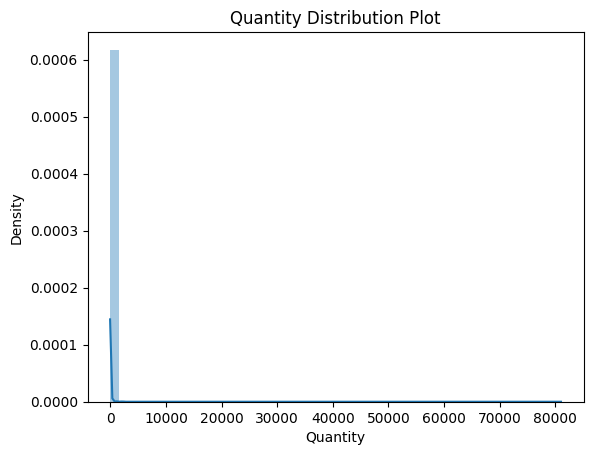

In [114]:
# plot distribution plot for quantity
sns.distplot(df.Quantity)
plt.title("Quantity Distribution Plot")

In this case we are using skewness to check how the data are distributed i.e either positive(right) or negative(left) and their symetry.
Good values for a well distributed data should be 0.

We will have to deal with this skewness later using some method to normalize the dataset. But in this case, these the data is not collected from a single country and each country has its own regulations for market and consumer purchasing patterns, we are not going to normalize the data in any way. We will just use it as it ease in order to caters iddifferences between each country's economic patterns.


- One of the thing we will deal with is If `Quantity or UnitPrice is less than or equal to Zero, we have to drops those values since they are outliers`. We cannot have an invoice order with zero Quantity or costs zero.

In [115]:
print(f"For Unit Price, {len(df[df['UnitPrice'] <= 0])}  Costs Nothing")
print(f"For Invoice Quantiy  {len(df[df['Quantity'] <= 0])}  Were Nothing")

For Unit Price, 40  Costs Nothing
For Invoice Quantiy  0  Were Nothing


In [116]:
# lets drop the Unit price that cost nothing
df = df[df["Quantity"] > 0]

# recheck shape
df.shape

(397924, 8)

In [117]:
country_counts =df['Country'].value_counts(normalize=True)
country_counts

United Kingdom          0.890484
Germany                 0.022723
France                  0.020964
EIRE                    0.018189
Spain                   0.006245
Netherlands             0.005938
Belgium                 0.005104
Switzerland             0.004629
Portugal                0.003674
Australia               0.002978
Norway                  0.002694
Italy                   0.001905
Channel Islands         0.001880
Finland                 0.001721
Cyprus                  0.001543
Sweden                  0.001133
Austria                 0.001000
Denmark                 0.000955
Poland                  0.000829
Japan                   0.000807
Israel                  0.000623
Unspecified             0.000613
Singapore               0.000558
Iceland                 0.000457
USA                     0.000450
Canada                  0.000379
Greece                  0.000364
Malta                   0.000281
United Arab Emirates    0.000171
European Community      0.000151
RSA       

- Majority of the Invoices i.e 89% were from United Kingdom

In [118]:
# check mean price agaist the country
table = df.groupby(['Country'],as_index=False)['Quantity'].median()
table = table.sort_values(by='Quantity',ascending=False)
table.style.background_gradient(cmap='Reds')

,Country,Quantity
23,Netherlands,72.000000
19,Japan,48.000000
0,Australia,32.000000
31,Sweden,24.000000
8,Czech Republic,24.000000
21,Lithuania,16.000000
32,Switzerland,12.000000
16,Iceland,12.000000
28,Saudi Arabia,12.000000
29,Singapore,12.000000


- From the above, Invoices ordered from Netherlands were average with 72 units which is almost twice Japan which it the second one with 48
- Most country had invoice orders with 10 as qiuantity.
- The least was United Kingdom and Unspecified with 4 and 2 respectively

In [119]:
# check country against unit price
table = df.groupby(['Country'],as_index=False)['UnitPrice'].median()
table = table.sort_values(by='UnitPrice',ascending=False)
table.style.background_gradient(cmap='Reds')

,Country,UnitPrice
20,Lebanon,3.950000
4,Brazil,3.320000
11,European Community,3.150000
2,Bahrain,2.950000
7,Cyprus,2.950000
27,RSA,2.950000
22,Malta,2.950000
6,Channel Islands,2.550000
21,Lithuania,2.550000
18,Italy,2.175000


- Lebanon Items were the most expensive with \$3.95 followed   by   brazil  with  \$3.32.
- Czech Republic was with the cheapest price of \$1.25


In [120]:
# check unique in descriptions for the pr0duct
#
df.Description.nunique()


3877

In [121]:
#unique for the stock
df.StockCode.nunique()

3665

- From the above, we can identify an issue, In this case there need to be similarities in the number of counts for Description and StockCode since the description describes the Stock.
- Since there are `3877 Descriptions` and `3665 StockCodes`, We are going to ensure each StockCode has its own descripption and those not with code be dropped.

In [122]:
# lets group against description and get its code
stock_desc = df[["Description","StockCode"]].drop_duplicates()
stock_desc = stock_desc.groupby(["Description"]).agg({"StockCode":"count"}).reset_index()
stock_desc.sample(2)

,Description,StockCode
3395,SWISS CHALET TREE DECORATION,1
3250,SMALL GLASS SUNDAE DISH CLEAR,1


In [123]:
# rename the above stockCode
stock_desc.rename(columns={'StockCode':'Code_Counter'},inplace=True)
stock_desc = stock_desc[stock_desc["Code_Counter"]>1]

# we then delete any product with more than 1 Code_Counter which is StockCode
df = df[~df["Description"].isin(stock_desc["Description"])]

In [124]:
df.shape

(396945, 8)

In [125]:
pd.__version__

'1.5.3'

In [126]:
# now lets group by stock code and get the results
stock_desc = df[["Description","StockCode"]].drop_duplicates()
stock_desc = stock_desc.groupby(["StockCode"]).agg({"Description":"count"}).reset_index()
stock_desc.rename(columns={'Description':'desc_Counter'},inplace=True)

# delete those with more than one Description
stock_desc = stock_desc[stock_desc["desc_Counter"] > 1]

# get only required data with a single description
df = df[~df["StockCode"].isin(stock_desc["StockCode"])]

In [127]:
df.shape

(358543, 8)

In [128]:
# now lets recheck the unique descriptions with their respective codes

print(f"Total number of Descriptions are  {df.Description.nunique()}")
print(f"Total number of StockCode are  {df.StockCode.nunique()}")

Total number of Descriptions are  3420
Total number of StockCode are  3420


- We now get similar number of counts in both columns

- We are done processing the data

## Apriori Algorithm Matrix Preparation
- We need to use Functions in order to easen up the process


In [129]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
5,536365,22752,SET 7 BABUSHKA NESTING BOXES,2,2010-12-01 08:26:00,7.65,17850.0,United Kingdom
6,536365,21730,GLASS STAR FROSTED T-LIGHT HOLDER,6,2010-12-01 08:26:00,4.25,17850.0,United Kingdom


In [130]:
# delete that with stockcode as post
df = df[~df["StockCode"].str.contains("POST", na=False)]

In [132]:
df.shape

(357444, 8)

In [133]:

def create_apriori_matric_for_products(data):
    """
    This functions groups the data against its invoice number and stock code and then create a matrix between them.
    @params: data: DataFrame - Data to be transformed
    @return: A dataframe object with unstacked matrix
    """
    return data.groupby(['InvoiceNo', "StockCode"])['Quantity'].sum().unstack().fillna(0).applymap(lambda val: 1 if val > 0 else 0)

In [134]:
# # lets test above function using sample data
# we are going query only german data
df_sample = df[df["Country"] == "Germany"]

invoice_group_sample = create_apriori_matric_for_products(df_sample)
invoice_group_sample.head()

StockCode,10002,10125,11001,15034,15036,15039,16008,16011,16014,16016,...,90160D,90161B,90161C,90161D,90201A,90201B,90201C,90201D,90202D,M
InvoiceNo,,,,,,,,,,,,,,,,,,,,,
536527,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
536840,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
536861,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
536967,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
536983,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0


In [169]:

#this function finds an item by its stock id
def find_stock_by_id(data, stockCode):
    """
    This functions return details of a product from stockcode given
    @param : stockCode : A string representing the code of the stock
    @returns
        StockCode: a string represeting selected stock code
        product_desc : Description of the product selected

    """
    product_desc = data[data["StockCode"] == stockCode]["Description"]
    #print(product_desc)
    product_desc = product_desc.unique()
    #print(product_desc)
    return stockCode, product_desc[0]

In [170]:
(df['StockCode'] == str("23286")).sum()

164

In [171]:
df.dtypes

InvoiceNo              object
StockCode              object
Description            object
Quantity                int64
InvoiceDate    datetime64[ns]
UnitPrice             float64
CustomerID            float64
Country                object
dtype: object

In [172]:
df["InvoiceNo"] = df["InvoiceNo"].astype(str)
df["StockCode"] = df["StockCode"].astype(str)

In [173]:
# df['StockCode']

In [174]:
df.dtypes

InvoiceNo              object
StockCode              object
Description            object
Quantity                int64
InvoiceDate    datetime64[ns]
UnitPrice             float64
CustomerID            float64
Country                object
dtype: object

In [175]:
# find_stock_by_id(df_sample, "21755")
(df['StockCode'] == "21755").sum()

580


### Determing the rule of association between different items.
- We will caclulate the support values for every possible config of each items and use a thresshold of 2% (0.02) for the choosen one

In [176]:
# get apriori frequency for items
apriori_freq_data = apriori(
    invoice_group_sample,
    min_support=0.02,
    use_colnames=True)

In [177]:
association_rules_in_market = association_rules(
    apriori_freq_data,
    metric="lift",
    min_threshold=0.01)

association_rules_in_market.sort_values(['confidence', 'lift'], ascending =[False, False]).head(5)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
575,(23291),(23289),0.024719,0.026966,0.024719,1.0,37.083333,0.024053,inf
570,(23285),(23286),0.024719,0.031461,0.024719,1.0,31.785714,0.023941,inf
583,(47590B),(47590A),0.020225,0.031461,0.020225,1.0,31.785714,0.019588,inf
774,"(21668, 21670)",(21672),0.020225,0.053933,0.020225,1.0,18.541667,0.019134,inf
792,"(21673, 21668)",(21672),0.020225,0.053933,0.020225,1.0,18.541667,0.019134,inf


In [178]:
x = [(23291,),(21668, 21670)	,(21673, 21668)]

for i, val in enumerate(x):
    for val_j in list(val):
        print(val_j)


for idx, product in enumerate(sorted_association_rules_in_market["antecedents"]):
    #since we saw antecent as tuple we need to get each item id
    for j in list(product):
        if str(j) == "23286":
            #lets get the id of current index
            items_recommended.append(list(sorted_association_rules_in_market.iloc[idx]["consequents"])[0])
            #remove duplicates using dictionary as key
            items_recommended = list( dict.fromkeys(items_recommended))

23291
21668
21670
21673
21668


### Some of the metrics from the above Association includes

- Antecedent- If X is called this way computes the proportion of transactions that contain the antecedent X.
- consequent support: If Y is called consequent, 'consequent support' computes the proportion of transactions that contain the antecedent Y.
- support: 'support' computes the proportion of transactions that contain the antecedent X and Y.
- confidence: Probability of buying Y when X is bought.
- lift: Represents how many times the probability of getting Y increases when X is received.

In [179]:
sorted_association_rules_in_market = association_rules_in_market.sort_values(['confidence', 'lift'], ascending =[False, False])


- We then need to develop strategy in which product will be recommended ie  When a customer buy product from Stock X, We sort it according the the probs that he have of buying product with Stock ID Y. This is through the use of `CONFIDENCE`. We can also use `LIFT` as how many times the probability of getting Y increases when X is received.
- In our case, we will use `HYBRID FILTERING` through the use of `SUPPORT, LIFT and CONFIDENCE`.

- General RULE will be `If a user buys a product with X ID, which products will he be recommended next?`

In [180]:
# we start by writing recommendation rules from here.
#we first get all the antecentednt from association rules and query item ids similar to the one a user bourgt

#check for 23286
# lets try recomment a user who has bought food with stockCode 23286
items_recommended = []
# iterate through all antecendents
for idx, product in enumerate(sorted_association_rules_in_market["antecedents"]):
    #since we saw antecent as tuple we need to get each item id
    for j in list(product):
        if str(j) == "23286":
            #lets get the id of current index
            items_recommended.append(list(sorted_association_rules_in_market.iloc[idx]["consequents"])[0])
            #remove duplicates using dictionary as key
            items_recommended = list( dict.fromkeys(items_recommended))

# print top 10 recommented products
for pro_id in items_recommended[:10]:
  #query the product by its id
  print(find_stock_by_id(df_sample, pro_id))

(23285, 'PINK VINTAGE SPOT BEAKER')
(23287, 'RED VINTAGE SPOT BEAKER')


- We have been able to create a recommentation for a product with id
- For easier working and utilization of the system, I will create a class where it object can be used to query recommended results from id passed.


In [186]:
class AprioriRecommentor:
    def __init__(self, data, min_support_val):
        self.data = data
        self.min_support_val =min_support_val
        #create association rule
        self.sorted_association_rules_in_market = self.create_Aprioli_ARL_rules()

    def create_apriori_matric_for_products(self):
        """
        This functions groups the data against its invoice number and stock code and then create a matrix between them.
        @params: data: DataFrame - Data to be transformed
        @return: A dataframe object with unstacked matrix
        """
        return self.data.groupby(['InvoiceNo', "StockCode"])['Quantity'].sum().unstack().fillna(0).applymap(lambda val: 1 if val > 0 else 0)


    #this function finds an item by its stock id
    def find_stock_by_id(self, stockCode):
        """
        This functions return details of a product from stockcode given
        @param : stockCode : A string representing the code of the stock
        @returns
            StockCode: a string represeting selected stock code
            product_desc : Description of the product selected

        """
        product_desc = self.data[self.data["StockCode"] == stockCode]["Description"].unique()
        #print(product_desc)
        return stockCode, product_desc[0]

    def create_Aprioli_ARL_rules(self):
        invoice_product_matrix = self.create_apriori_matric_for_products()
        # get apriori frequency for items
        apriori_freq_data = apriori(
            invoice_product_matrix,
            min_support= self.min_support_val,
            use_colnames=True)
        association_rules_in_market = association_rules(
            apriori_freq_data,
            metric="lift",
            min_threshold=self.min_support_val)
        #sort these rules
        sorted_association_rules_in_market = association_rules_in_market.sort_values(['confidence', 'lift'], ascending =[False, False])

        return sorted_association_rules_in_market

    def recommend_product_to_user(self, prod_id, max_recommendent_items =10):
        # lets try recomment a user who has bought food with stockCode `prod_id`
        items_recommended = []
        # iterate through all antecendents
        for idx, product in enumerate(self.sorted_association_rules_in_market["antecedents"]):
            #since we saw antecent as tuple we need to get each item id
            for j in list(product):
                if str(j) == str(prod_id):
                    #lets get the id of current index
                    items_recommended.append(list(self.sorted_association_rules_in_market.iloc[idx]["consequents"])[0])
                    #remove duplicates using dictionary as key
                    items_recommended = list( dict.fromkeys(items_recommended))


        return items_recommended[:max_recommendent_items]


    def show_products_recommended_to_user(self,prod_id, max_recommendent_items=10):
        #check if product id is present
        if str(prod_id) in list(self.data["StockCode"].astype("str").unique()):
            print("We fouund some products...")
            #get the recommended list
            recommended_product_list = self.recommend_product_to_user(str(prod_id), max_recommendent_items)
            #check if there was any product recommended to the user i.e if list is empty
            if len(recommended_product_list) == 0:
                return {"Product_Code":prod_id,"data":[], "advice":"There was no any product that can be recommended to this user"}
            else:
                res = []
                for index in range(0, len(recommended_product_list)):
                    #print(recommended_product_list, "Recommended list")
                    curr_product = self.find_stock_by_id(recommended_product_list[index])
                    res.append({
                        "Product_code": curr_product[0],
                        "Description": curr_product[1]
                    })

                return {"Product_Code":prod_id,"data":res, "advice":"We have the following products recommended for you"}

        else:
            return {"Product_Code":prod_id,"data":[], "advice":f"Code  {prod_id} was invalid as it is not in the stock"}




In [187]:
# let test it
aprioli_ARL_recommended_object = AprioriRecommentor(df, 0.01)

In [188]:
# check recommendation for product 22326
aprioli_ARL_recommended_object.show_products_recommended_to_user(22326)


We fouund some products...


{'Product_Code': 22326,
 'data': [{'Product_code': '22328',
   'Description': 'ROUND SNACK BOXES SET OF 4 FRUITS '}],
 'advice': 'We have the following products recommended for you'}

In [83]:
# check recommendation for product 21086
aprioli_ARL_recommended_object.show_products_recommended_to_user(21086)

['SET/6 RED SPOTTY PAPER PLATES']
['SET/20 RED RETROSPOT PAPER NAPKINS ']


{'Product_Code': 21086,
 'data': [{'Product_code': 21094,
   'Description': array(['SET/6 RED SPOTTY PAPER PLATES'], dtype=object)},
  {'Product_code': 21080,
   'Description': array(['SET/20 RED RETROSPOT PAPER NAPKINS '], dtype=object)}],
 'advice': 'We have the following products recommended for you'}

In [189]:
# check recommendation for product 21
aprioli_ARL_recommended_object.show_products_recommended_to_user(21)

{'Product_Code': 21,
 'data': [],
 'advice': 'Code  21 was invalid as it is not in the stock'}

In [190]:
# check recommendation for product 22112
aprioli_ARL_recommended_object.show_products_recommended_to_user(22112)

We fouund some products...


{'Product_Code': 22112,
 'data': [{'Product_code': '22835',
   'Description': 'HOT WATER BOTTLE I AM SO POORLY'},
  {'Product_code': '22114',
   'Description': 'HOT WATER BOTTLE TEA AND SYMPATHY'},
  {'Product_code': '23355', 'Description': 'HOT WATER BOTTLE KEEP CALM'},
  {'Product_code': '22111', 'Description': 'SCOTTIE DOG HOT WATER BOTTLE'}],
 'advice': 'We have the following products recommended for you'}

In [191]:
# check recommendation for product 20712
aprioli_ARL_recommended_object.show_products_recommended_to_user(20712)

We fouund some products...


{'Product_Code': 20712,
 'data': [{'Product_code': '85099B', 'Description': 'JUMBO BAG RED RETROSPOT'},
  {'Product_code': '22386', 'Description': 'JUMBO BAG PINK POLKADOT'}],
 'advice': 'We have the following products recommended for you'}

In [192]:
# !pip freeze

- We have been able to build this recommendor system and it is working correctly.
- Lets now save the object into a pickle file for usage later.

In [194]:
# import pickle

# with open("recommender_model.pkl", "wb") as rec_object:
#     pickle.dump(aprioli_ARL_recommended_object, rec_object)
#     rec_object.close()



pd.to_pickle(aprioli_ARL_recommended_object, "final_model.pkl")

print("Finished saving....")

Finished saving....


In [196]:

with open("./final_model.pkl", "rb") as model_object:
    model = pickle.load(model_object)

    model_object.close()


res = model.show_products_recommended_to_user(20712)

print(res)

We fouund some products...
{'Product_Code': 20712, 'data': [{'Product_code': '85099B', 'Description': 'JUMBO BAG RED RETROSPOT'}, {'Product_code': '22386', 'Description': 'JUMBO BAG PINK POLKADOT'}], 'advice': 'We have the following products recommended for you'}


In [197]:
pd.__version__

'1.5.3'